# Kaggle Fruits 360 with CNN
let's work with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
You'll want to be comfortable with below theories:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

## Perform standard imports

In [141]:
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

## Define common methods

In [142]:
def Check_CUDA():
    no_cuda = False
    is_cuda = not no_cuda and torch.cuda.is_available()
    print("is_cuda = ", is_cuda)
    # check if there is GPU
    if is_cuda:
        cuda_device = 0
        torch.cuda.set_device(cuda_device)
        torch.backends.cudnn.benchmark = True
    kwargs = {'num_workers': 4, 'pin_memory': True} if is_cuda else {}
    return is_cuda, kwargs



def find_classes(dir):
    image_classes = []
    for file in os.scandir(dir):
        if file.is_dir():
            image_classes.append(file.name)
    # sort image as scandir returned random order
    image_classes.sort()        
    return image_classes

In [143]:
path  = '/fruits-360'
image_classes = find_classes(os.path.join(path, 'Training'))
print(image_classes)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

## Load the Fruits360 dataset
PyTorch load data using torchvision's ImageFolder
Refer to:
<a href='https://pytorch.org/docs/stable/data.html#torchvision.datasets.ImageFolder'><tt><strong>ImageFolder</strong></tt></a>.
Refer for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.


In [144]:
transform = transforms.ToTensor()

train_data = ImageFolder(root= os.path.join(path, 'Training'), transform=transform)
test_data = ImageFolder(root=os.path.join(path, 'Test'), transform=transform)

## Create loaders
When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [145]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Define a convolutional model
CNN with input layer of 10000 (our flattened 100x100 images), and an output size representing 131 possible digits.
This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

In [146]:
# Define layers
# out_channels: filters,
# nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1)
conv1 = nn.Conv2d(3, 8, 3, 1)  # ----> 6 filters -----> pooling ----> conv2
# arbitrary value for filters
conv2 = nn.Conv2d(8, 16, 3, 1)

# In[10]:


# Grab the first record
for i, (X_train, y_train) in enumerate(train_data):
    break

# In[11]:


X_train.shape

# In[12]:


# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)

x = X_train.view(1, 3, 100, 100)
print(x.shape)

# In[13]:


# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)  # [1, 8, 98, 98] ----> 98 = 100 - 3(kernel) + 1(stride)

# In[14]:


# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

# In[15]:


# Perform the second convolution/activation
x = F.relu(conv2(x))
# print(x.shape)

# In[16]:


# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)  # [1, 16, 23, 23] ---> 47/2=23.5
# ( (pixel - 2)/2<pooling> - 2<kernel loss> ) /2
# 100-2
print(x.shape)

# In[17]:


((100 - 2) / 2 - 2) / 2

# In[18]:


x.shape

# In[19]:


# Flatten the data
# -1: keep the first dimension, batch size
x = x.view(-1, 16 * 23 * 23)
print(x.shape)


# <div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>
#
# Now let's run the code.

torch.Size([1, 3, 100, 100])
torch.Size([1, 8, 98, 98])
torch.Size([1, 8, 49, 49])
torch.Size([1, 16, 23, 23])
torch.Size([1, 8464])


In [147]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1)
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        # 120 is arbitrary choice of how many nutron we want
        self.fc1 = nn.Linear(16 * 23 * 23, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 131)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 23 * 23)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [148]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
is_cuda = Check_CUDA()
if is_cuda:
    model.cuda()

is_cuda =  True


In [149]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [150]:
count_parameters(model)

   216
     8
  1152
    16
2539200
   300
 60000
   200
 26200
   131
______
2627423


## Define loss function & optimizer

In [151]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [154]:

import time

start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []


best_val_acc = 0
best_model_file_name = type(model).__name__ +'_best_checkpoint.pickle'


for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        if is_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
            X_train = X_train.type('torch.cuda.FloatTensor')
            y_train = y_train.type('torch.cuda.LongTensor')
            y_train = y_train.squeeze()
        else:
            X_train = X_train.type('torch.DoubleTensor')
            y_train = y_train.type('torch.LongTensor')

        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % 600 == 0:
            print(
                f'epoch: {i:2}  batch: {b:4} [{10 * b:6}/60000]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item() * 100 / (10 * b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for bb, (X_test, y_test) in enumerate(test_loader):


            if is_cuda:
                X_test = X_test.cuda()
                y_test = y_test.cuda()
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    # if is_cuda:
    #     test_correct = test_correct.cpu()
    val_pred_acc =  test_correct[i].cpu().numpy()/(10*(bb + 1))
    #print('bb: ', bb+1)
    print('Epoch ',i,"--- test_correct:",val_pred_acc)

    if val_pred_acc > best_val_acc:
        best_val_acc = val_pred_acc

        torch.save({'state_dict': model.state_dict(),
                    'epoch': i,
                    'best_val_pred_acc': val_pred_acc,
                    'class2idx': image_classes,
                    'Data_path': path}, best_model_file_name)




print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

epoch:  0  batch:  600 [  6000/60000]  loss: 0.00001544  accuracy:  98.467%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00002582  accuracy:  98.350%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.15783408  accuracy:  98.472%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.16792156  accuracy:  98.300%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00008452  accuracy:  98.453%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00342316  accuracy:  98.597%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00088376  accuracy:  98.512%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00350780  accuracy:  98.596%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00560264  accuracy:  98.585%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.38959819  accuracy:  98.555%
epoch:  0  batch: 6600 [ 66000/60000]  loss: 0.00000083  accuracy:  98.576%
Epoch  0 --- test_correct: 0.9260026443367122
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00014017  accuracy:  99.133%
epoch:  1  batch: 1200 [ 12000/60000]  los

epoch:  9  batch: 3000 [ 30000/60000]  loss: 0.00000000  accuracy:  99.347%
epoch:  9  batch: 3600 [ 36000/60000]  loss: 0.00000000  accuracy:  99.414%
epoch:  9  batch: 4200 [ 42000/60000]  loss: 0.00000000  accuracy:  99.490%
epoch:  9  batch: 4800 [ 48000/60000]  loss: 0.00000026  accuracy:  99.365%
epoch:  9  batch: 5400 [ 54000/60000]  loss: 0.00000000  accuracy:  99.383%
epoch:  9  batch: 6000 [ 60000/60000]  loss: 0.00000000  accuracy:  99.440%
epoch:  9  batch: 6600 [ 66000/60000]  loss: 0.00003038  accuracy:  99.470%
Epoch  9 --- test_correct: 0.9020713970912296

Duration: 429 seconds


## Insert 'train correct & loss', 'test correct & loss' record into pickle file.

In [155]:
best_point = torch.load(best_model_file_name)
best_point.update([('train_correct', train_correct),
                        ('train_losses', train_losses),
                   ('test_losses',test_losses),
                   ('test_correct',test_correct)
                   ])
torch.save(best_point,best_model_file_name)


t = time.strftime("%Y%m%d_%H-%M-%S", time.localtime())   # time stamp for the file was saved
exist_check_point = os.path.isfile(best_model_file_name)
this_data = os.path.split(path)[-1]  # data folder
print(this_data)

fruits-360


## save the best model to result folder

In [156]:
if exist_check_point:
    new_check_point_name = this_data + '_channel-' + str(3) + '_test_acc-' + '{:.2f}'.format(best_val_acc*100)+ '_' + type(model).__name__ + 'final_pack' + '_' + t + '.pickle'
    os.rename(best_model_file_name, new_check_point_name)

## Plot the loss and accuracy comparisons

b+1: 6771
bb+1: 2269


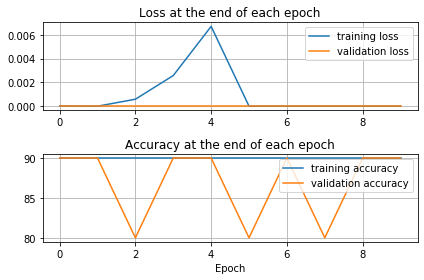

In [157]:
print('b+1:', b+1)
print('bb+1:', bb+1)
# load the best "model" to model
best_point = torch.load(new_check_point_name)
model.load_state_dict(best_point['state_dict'])
fig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].plot(train_losses, label='training loss')
axs[0].plot(test_losses, label='validation loss')
axs[0].title.set_text('Loss at the end of each epoch')
axs[0].legend();
axs[0].grid(True)

axs[1].plot([t /6771*10  for t in train_correct], label='training accuracy')
axs[1].plot([t /2269*10  for t in test_correct], label='validation accuracy')
axs[1].title.set_text('Accuracy at the end of each epoch')
axs[1].legend();
axs[1].grid(True)
axs[1].set_xlabel('Epoch', fontsize=10)

fig.tight_layout()
plt.show()

# Evaluate the Test data

In [158]:
test_load_all = DataLoader(test_data, batch_size=5000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if is_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_test = y_test.squeeze()
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item() * 100 / (len(test_data)):7.3f}%')

Test accuracy: 21392/22688 =  94.288%


## Display the confusion matrix

In [159]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1, 10))
print()

# print the confusion matrix
if is_cuda:
    predicted = predicted.cpu()
    y_test = y_test.cpu()
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    8    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   29    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   11    0    0    0    0    0]
 [   0    0    0    0    0    0    0   22    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  209    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0  166    0    0    0    

# Exam missed predictions
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [160]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype('int64')

# Display the number of misses
print(len(misses))


# Display the first 10 index positions
misses[:10]

74


array([  37,   40,   48,   63,   79,  161,  172,  173,  174,  175])

Index: [  37   40   48   63   79  161  172  173  174  175  176]
Label: [ 117  117  117  117  117  117  117  117  117  117  117]
Guess: [ 108  108   10  108  112   32  126   53   53   53   53]


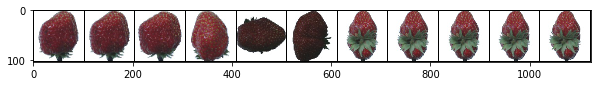

In [161]:
# Set up an iterator to feed batched rows
r = 12  # row size
row = iter(np.array_split(misses, len(misses) // r + 1))

# Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
# Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.


nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0, torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0, torch.tensor(nextrow)).numpy())
if is_cuda:
    X_test = X_test.cpu()
images = X_test.index_select(0, torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()

# Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the Fruits360 test set.

torch.Size([3, 100, 100])


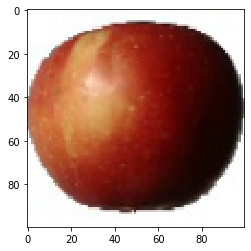

Predicted value: 0 , Predicted Class: Apple Braeburn


In [162]:

x = 1
image = test_data[x][0] 
#print(image.shape)

im = make_grid(image, nrow=1)
print(image.shape)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()
# In[32]:


model.eval()
with torch.no_grad():
    if is_cuda:
        new_pred = model(test_data[x][0].view(1, 3, 100, 100).cuda()).argmax()
        new_pred = new_pred.cpu()
    else:
        new_pred = model(test_data[x][0].view(1,3, 100, 100)).argmax()
print("Predicted value:",new_pred.item(), ', Predicted Class:', image_classes[new_pred.item()])
